In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import catboost as cb
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ( f1_score, classification_report, 
                             confusion_matrix, roc_auc_score,
                             accuracy_sc# print(tick_props * n_pokemon) ore, roc_curve )

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline 
import optuna 

In [2]:
warnings.simplefilter(action='ignore')
%matplotlib inline
plt.style.use('seaborn-notebook')
plt.rcParams["figure.figsize"] = (12, 6)
sns.set(context="paper", font="monospace") 

## Read and Clean Data

In [3]:
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')
sub_df = pd.read_csv('SampleSubmission.csv')

In [4]:
train_df.head()

,region_area_,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,region_area_1,3.716080,180.196811,18630.362669,6.330435,NaN,602.990359,15.285013,56.444076,4.500656,0
1,region_area_100,4.270716,217.611599,24405.555346,7.086700,297.951852,359.623910,13.583526,54.589840,3.763906,0
2,region_area_1000,6.648849,232.462013,30733.808648,5.656462,344.670335,267.809179,17.863444,35.411181,4.827527,0
3,region_area_1001,NaN,261.753637,21174.713291,7.314074,NaN,582.848407,15.215849,90.367455,4.217553,0
4,region_area_1002,9.323584,263.484560,15751.480111,5.196259,297.593625,409.878704,10.727265,74.669285,3.006650,0


In [5]:
sub_df.sample(5) 

,region_area_,Potability
781,region_area_349,1
16,region_area_1044,1
755,region_area_3224,1
978,region_area_913,1
618,region_area_2827,1


In [6]:
train_df["source"] = 'train'
test_df["source"] = 'test'

data = pd.concat([train_df, test_df]).reset_index(drop=True)
print(data.shape)
print(train_df.shape)
print(test_df.shape) 

(3276, 12)
(2260, 12)
(1016, 11)


In [7]:
stats = []
for col in data.columns:
    stats.append((col, data[col].nunique(), data[col].isnull().sum() * 100 / data.shape[0],
                  round((data[col].value_counts(normalize=True, dropna=False).values[0] * 100),2), 
                  data[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'missing values %', 
                                        'biggest category %', 'type']) 
stats_df.sort_values('missing values %', ascending=False) 

,Feature,Unique_values,missing values %,biggest category %,type
10,Potability,2,31.013431,42.19,float64
5,Sulfate,2495,23.840049,23.84,float64
1,ph,2785,14.987790,14.99,float64
8,Trihalomethanes,3114,4.945055,4.95,float64
0,region_area_,3276,0.000000,0.03,object
2,Hardness,3276,0.000000,0.03,float64
3,Solids,3276,0.000000,0.03,float64
4,Chloramines,3276,0.000000,0.03,float64
6,Conductivity,3276,0.000000,0.03,float64
7,Organic_carbon,3276,0.000000,0.03,float64


In [8]:
data.drop('region_area_', axis=1, inplace=True)

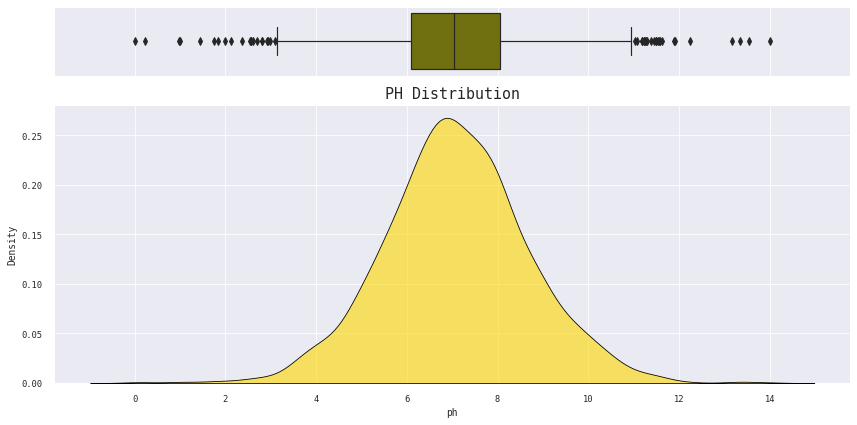

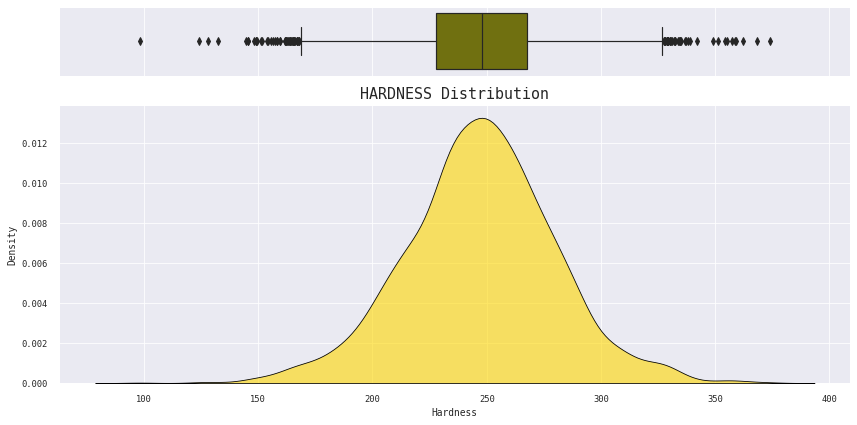

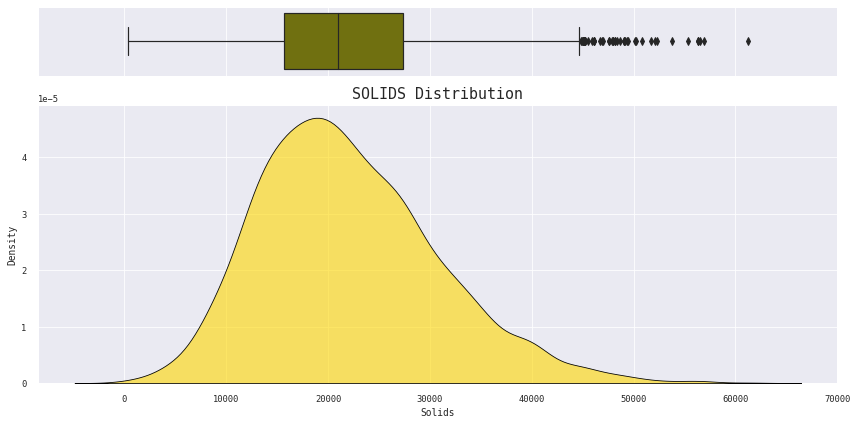

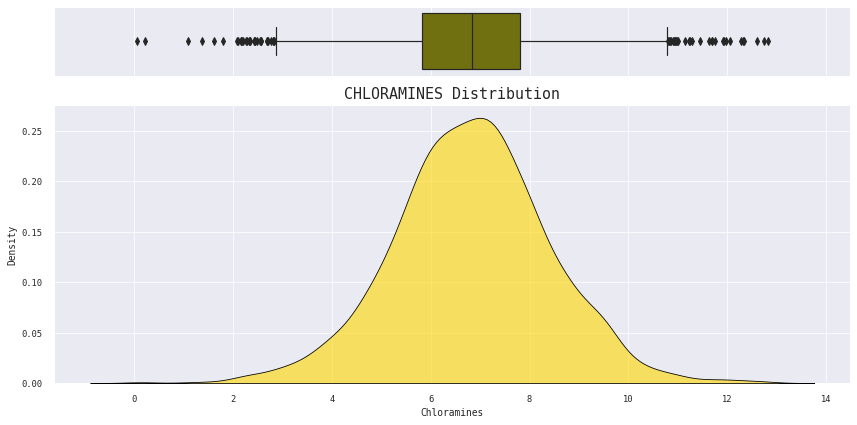

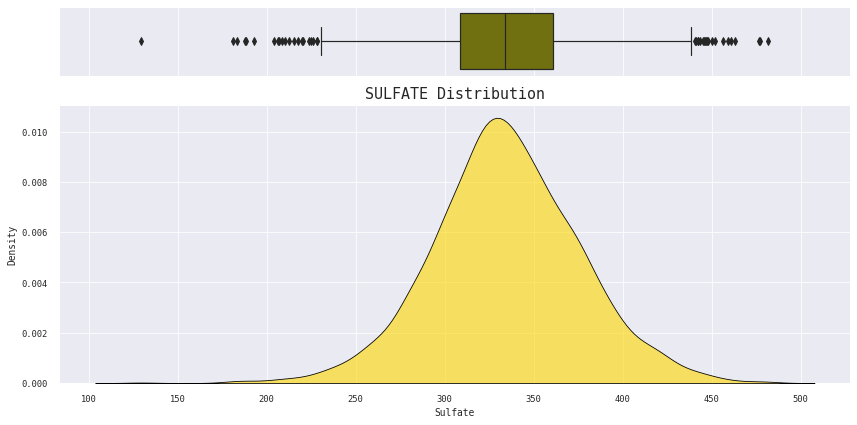

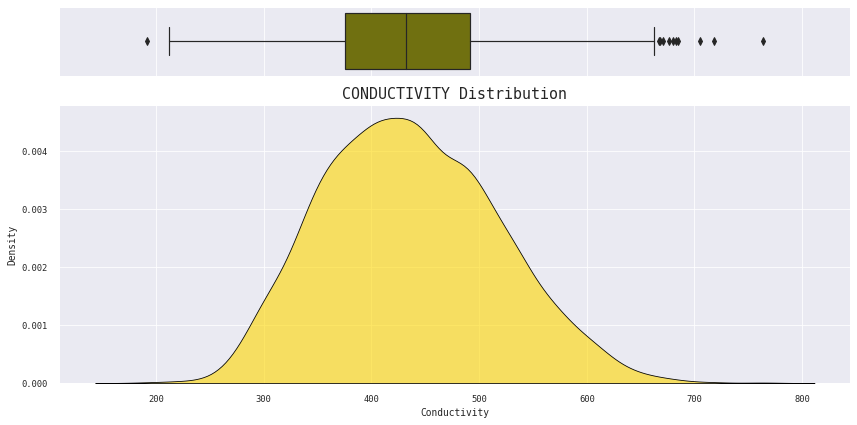

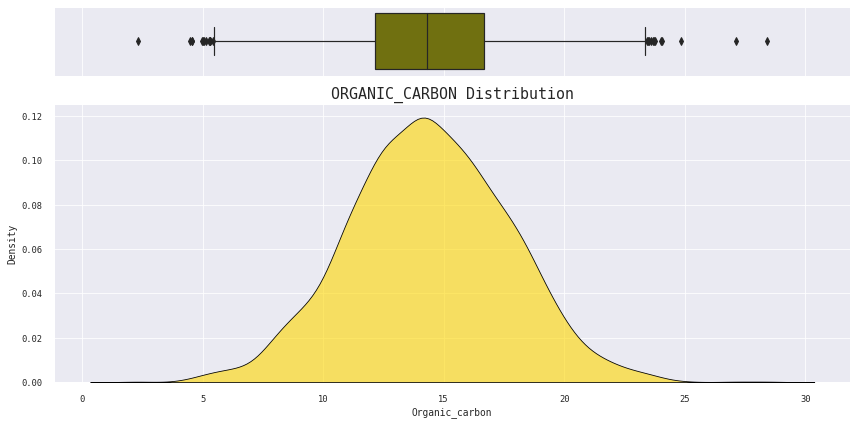

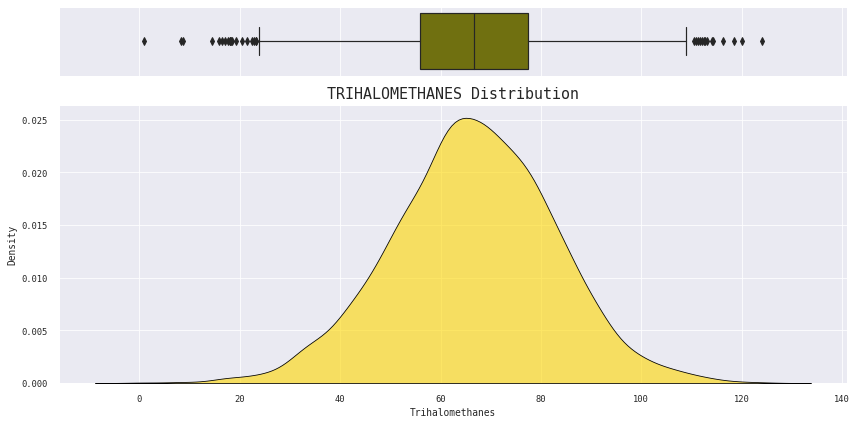

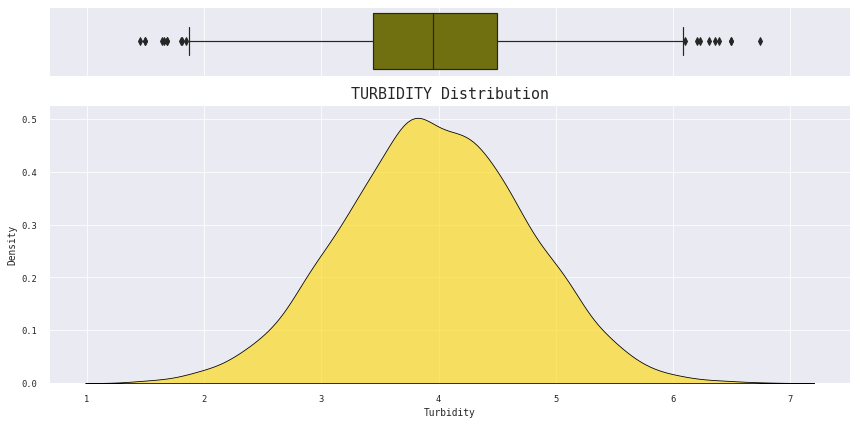

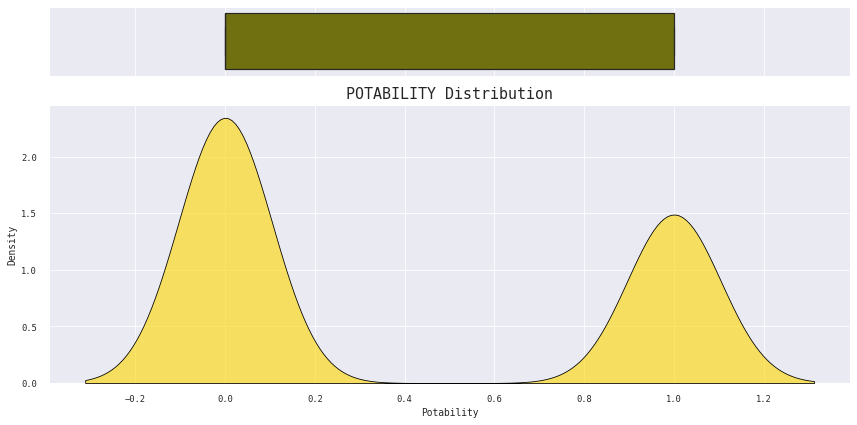

In [9]:
num_feat = list(data.select_dtypes(exclude = object).columns)

for col in data[num_feat]:
    ax = [None for i in range(2)]
    # set 2 subplots and set ratio of plots 
    f, (ax[0], ax[1]) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.20, .80)
                                        })   
    g1 = sns.boxplot(col, ax=ax[0], data=data, color='olive') # boxplot
    g1.set(xlabel=None) # remove x axis label for boxplot
    g2 = sns.kdeplot(data[col], ax=ax[1], shade=True, color='gold', alpha=0.6, 
                     zorder=3, edgecolor='black') # distribution plot
    plt.title(col.upper()+' Distribution', size=15)
    plt.tight_layout()
    plt.show()

In [10]:
# remove outlier in sulfate column
# Q3 = data["Sulfate"].quantile(0.99)
# data = data[data["Sulfate"] <= Q3]
# Q1 = data["Sulfate"].quantile(0.01)
# data = data[data["Sulfate"] >= Q1] 

In [11]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

missing_indx = list(data['Sulfate'][data['Sulfate'].isna()].index)

# Run the imputer with a simple Random Forest estimator
imp = IterativeImputer(RandomForestRegressor(n_estimators=5), max_iter=5, random_state=1)
to_train = ['Sulfate', 'Chloramines', 'Organic_carbon','ph', 'Trihalomethanes']

#perform filling
data[to_train] = pd.DataFrame(imp.fit_transform(data[to_train]), columns=to_train)

#display some of the filled values
data['Sulfate'][missing_indx].head(10)  

0     352.736501
3     344.128279
10    344.025078
11    299.236312
18    355.578311
19    341.440801
20    346.868870
26    340.569562
48    312.395381
63    326.277488
Name: Sulfate, dtype: float64

In [12]:
data.isna().sum() 

ph                    0
Hardness              0
Solids                0
Chloramines           0
Sulfate               0
Conductivity          0
Organic_carbon        0
Trihalomethanes       0
Turbidity             0
Potability         1016
source                0
dtype: int64

In [11]:
# data['Sulfate'].fillna(data['Sulfate'].median(), inplace=True)
# data['ph'].fillna(data['ph'].median(), inplace=True) 
# data['Trihalomethanes'].fillna(data['Trihalomethanes'].median(), inplace=True) 

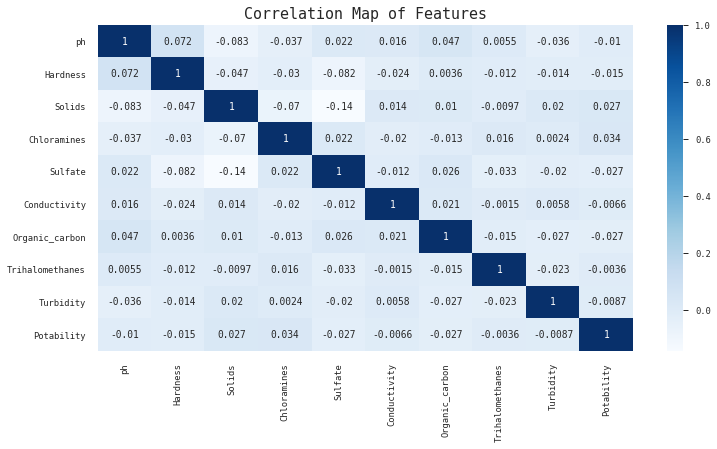

In [13]:
sns.heatmap(data.corr(), cmap='Blues', annot=True)
plt.title('Correlation Map of Features', size=15);

In [14]:
# data['exp_ph'] = np.exp(data['ph']) 
data['log_Sulfate'] = np.log(data['Sulfate']) 
# data.drop('exp_ph', axis=1, inplace=True)

In [15]:
# get back train and test data from data
train_df = data.loc[data["source"] == 'train']
test_df = data.loc[data["source"] == 'test'] 

In [16]:
test_df.drop(["source", "Potability"], axis=1, inplace=True)
train_df.drop(["source"], axis=1, inplace=True) 

## Train and Predict

In [17]:
y = train_df['Potability'].astype('int')
X = train_df.drop(['Potability'], axis=1)

In [18]:
y.unique()

array([0, 1])

In [19]:
print(X.shape, y.shape) 

(2260, 10) (2260,)


In [20]:
def fit_predict(model, X, y, K, test_df, plot=True, sampling=False):
    ''' Description
        -----------
        Train model specified on dataset using StratifiedKFold
        and resampling (optional)
        
        Parameters
        ----------
        model : sklearn model
            Machine learning model to be trained 
        X : pandas dataframe
          Training dataset
        y : pandas series 
          Target column, must have same number of observations with X
        K : int
          Number of folds for StratifiedKFold
        typ : str
          Training method, kept for model comparison
        plot : bool, optional
          Show roc-auc training plot (optional)
        sampling : bool, optional
          Use resample data for training 
        show: bool, optional
          Print number of observations after resampling
          
        Returns
        --------
        average confusion matrix, classification report, model name
        and roc curve
    '''
    
    # set initial scores
    scores = 0
    auc_scores = 0
    # set empty list to store predictions on test set
    test_oofs = []
    # get model name
    model_name = type(model).__name__
    # set a zero matrix of shape (2,2) for confusion matrix
    matrix = np.zeros((2, 2))
    # set up empty lists to extend true and predicted values
    originalclass = []
    predictedclass = []
    probclass = []
    train_accuracies, test_accuracies = [0.5], [0.5]

    # initiate StratifiedKFold
    kfold = StratifiedKFold(n_splits=K, shuffle=True, random_state=1)

    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        # scale the training dataset
        X_train = scaler.transform(X_train)
        # scale the test dataset
        X_test = scaler.transform(X_test)

        if sampling:
            # oversampling and undersampling 
            # define pipeline
            over = SMOTE(random_state=1)
            under = RandomUnderSampler(random_state=1)
            steps = [('o', over), ('u', under)]
            pipeline = Pipeline(steps=steps)

            # resample train dataset
            X_train, y_train = pipeline.fit_resample(X_train, y_train)

        # training
        if model_name in ['VotingClassifier', 'RandomForestClassifier', 
                          'SVC']:
            model.fit(X_train, y_train)
        else:
            model.fit(X_train, y_train,
                      early_stopping_rounds=300,
                      eval_set=[(X_test, y_test)],
                      verbose=False)
            
        # predicting on test set
        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)[:, 1]
        # predict on train test
        train_prob = model.predict_proba(X_train)[:, 1]
        # append y_test and pred list to original class and predicted class
        # lists respectively
        originalclass.extend(y_test)
        predictedclass.extend(pred)
        probclass.extend(prob)
        # get F1-score and roc_auc_score
        score = f1_score(y_test, pred, average='macro')
        roc = roc_auc_score(y_test, prob)
        train_roc = roc_auc_score(y_train, train_prob)
        # append roc-auc for train and test
        train_accuracies.append(train_roc)
        test_accuracies.append(roc)
        # take mean of scores
        scores += score/K
        auc_scores += roc/K
        test_oofs.append(pred)
        # sum confusion matrix of each fold to matrix
        matrix += confusion_matrix(y_test, pred)

        if i % 4 == 0:
            print('Fold {} F1-score: {}'.format(i+1, score))
            print('Fold {} ROC-AUC score: {}'.format(i+1, roc))
            print('='*45)

    print()
    print('Avg F1 score: {:.4f} '.format(scores))
    print('Avg ROC-AUC score: {:.4f} '.format(auc_scores))
        
    if plot:
        # plot train and test roc-auc
        plt.figure(figsize=(10, 5))
        plt.plot(train_accuracies, label="train roc-auc")
        plt.plot(test_accuracies, label="test roc-auc")
        plt.legend(loc="lower right", prop={'size': 12})
        plt.xticks(range(0, K, 5))
        plt.xlabel("fold", size=12)
        plt.ylabel("roc-auc", size=12)
        plt.show() 
    # make prediction on test set for submission
    test_df = scaler.transform(test_df)

    predictions = model.predict(test_df)
    # get classification report
    report = classification_report(originalclass, predictedclass)
    # curve_ = roc_curve(originalclass, probclass) 

    Model.append(model)
    F1Score.append(scores) 

    return matrix, report,  model, predictions  

In [21]:
def importance_plot(model, X, sample=''):
    ''' Description: Creates feature importance plot for a trained model
        Arguements: model - trained model on dataset
                    X - training dataset
                    sample - sampling method
    '''
    model_name = type(model).__name__
    if model_name in ['LogisticRegression', 'LinearRegression']:
        feat_imp = pd.DataFrame(sorted(zip(model.coef_[0], X.columns)),
                                columns=['Value', 'Feature'])
    else:
        feat_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns)),
                                columns=['Value', 'Feature'])
    plt.figure(figsize=(20, 15))
    imp_data = feat_imp.sort_values(by="Value", ascending=False)
    sns.barplot(x="Value", y="Feature", data=imp_data.iloc[:50])
    plt.ylabel('Feature Importance Score')
    plt.title(model_name + ' ' + sample + ' Feature Importance', size=15)
    plt.show()

In [23]:
Model = []
F1Score = [] 

### SVC

Fold 1 F1-score: 0.6756789971734054
Fold 1 ROC-AUC score: 0.7173469387755103
Fold 5 F1-score: 0.5385281385281384
Fold 5 ROC-AUC score: 0.5994897959183674
Fold 9 F1-score: 0.6356356356356356
Fold 9 ROC-AUC score: 0.7095959595959596
Fold 13 F1-score: 0.6493506493506493
Fold 13 ROC-AUC score: 0.707012987012987
Fold 17 F1-score: 0.6832579185520362
Fold 17 ROC-AUC score: 0.7475324675324675
Fold 21 F1-score: 0.6527777777777777
Fold 21 ROC-AUC score: 0.7122077922077923
Fold 25 F1-score: 0.6650717703349283
Fold 25 ROC-AUC score: 0.6846753246753248

Avg F1 score: 0.6132 
Avg ROC-AUC score: 0.6661 


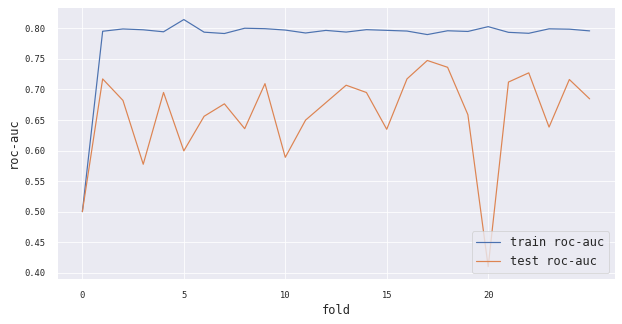

In [25]:
from sklearn.svm import SVC
sv = SVC(probability=True)

sv_matrix, sv_report, sv_1, sv_pred = fit_predict(sv, X, y, 25, test_df, sampling=True)   


### Xgb

Fold 1 F1-score: 0.6309450657490474
Fold 1 ROC-AUC score: 0.6908163265306122
Fold 5 F1-score: 0.6484735202492211
Fold 5 ROC-AUC score: 0.6760204081632653
Fold 9 F1-score: 0.6093434343434343
Fold 9 ROC-AUC score: 0.6818181818181819
Fold 13 F1-score: 0.6685714285714286
Fold 13 ROC-AUC score: 0.7215584415584416
Fold 17 F1-score: 0.6028243601059134
Fold 17 ROC-AUC score: 0.6914285714285714
Fold 21 F1-score: 0.6691176470588234
Fold 21 ROC-AUC score: 0.7579220779220779
Fold 25 F1-score: 0.6860059439204031
Fold 25 ROC-AUC score: 0.6935064935064935

Avg F1 score: 0.6219 
Avg ROC-AUC score: 0.6792 


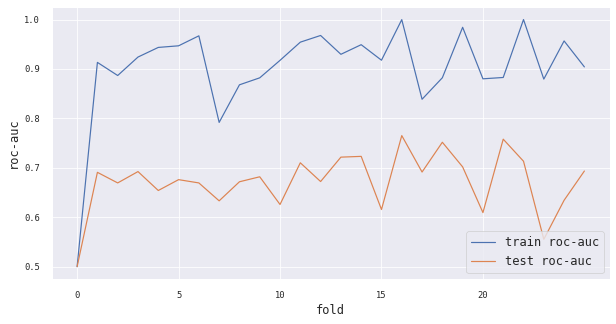

In [26]:
xgboost = xgb.XGBClassifier(eval_metric='logloss')
xgb_matrix, xgb_report, xgb_1, xgb_pred = fit_predict(xgboost, X, y, 25, test_df, sampling=True)  

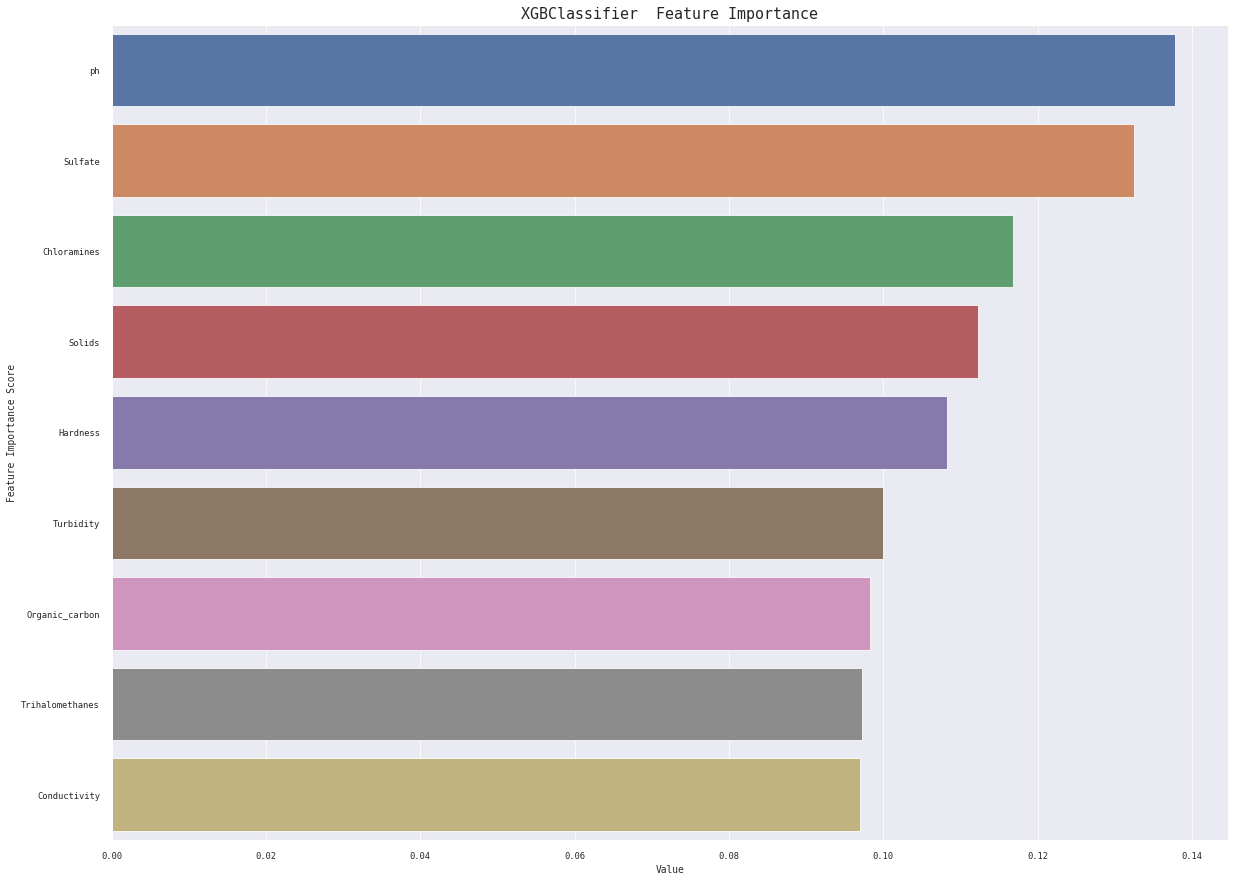

In [24]:
importance_plot(xgb_1, X) 

### Rf

Fold 1 F1-score: 0.6388888888888888
Fold 1 ROC-AUC score: 0.6826530612244898
Fold 5 F1-score: 0.5523726851851851
Fold 5 ROC-AUC score: 0.5915816326530613
Fold 9 F1-score: 0.5787037037037037
Fold 9 ROC-AUC score: 0.7421717171717173
Fold 13 F1-score: 0.6465454545454545
Fold 13 ROC-AUC score: 0.7202597402597403
Fold 17 F1-score: 0.6203636363636365
Fold 17 ROC-AUC score: 0.6979220779220777
Fold 21 F1-score: 0.6370967741935484
Fold 21 ROC-AUC score: 0.7623376623376623
Fold 25 F1-score: 0.6494781118554291
Fold 25 ROC-AUC score: 0.6883116883116883

Avg F1 score: 0.5928 
Avg ROC-AUC score: 0.6566 


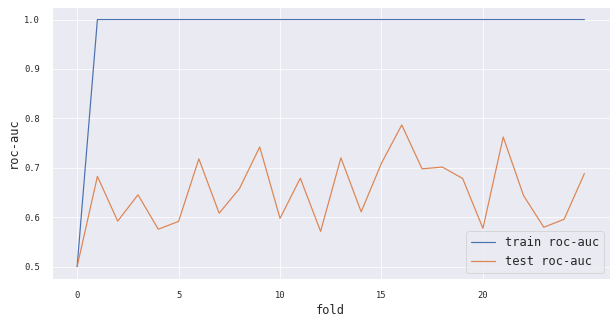

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_matrix, rf_report, rf_1, rf_pred = fit_predict(rf, X, y, 25, test_df)  

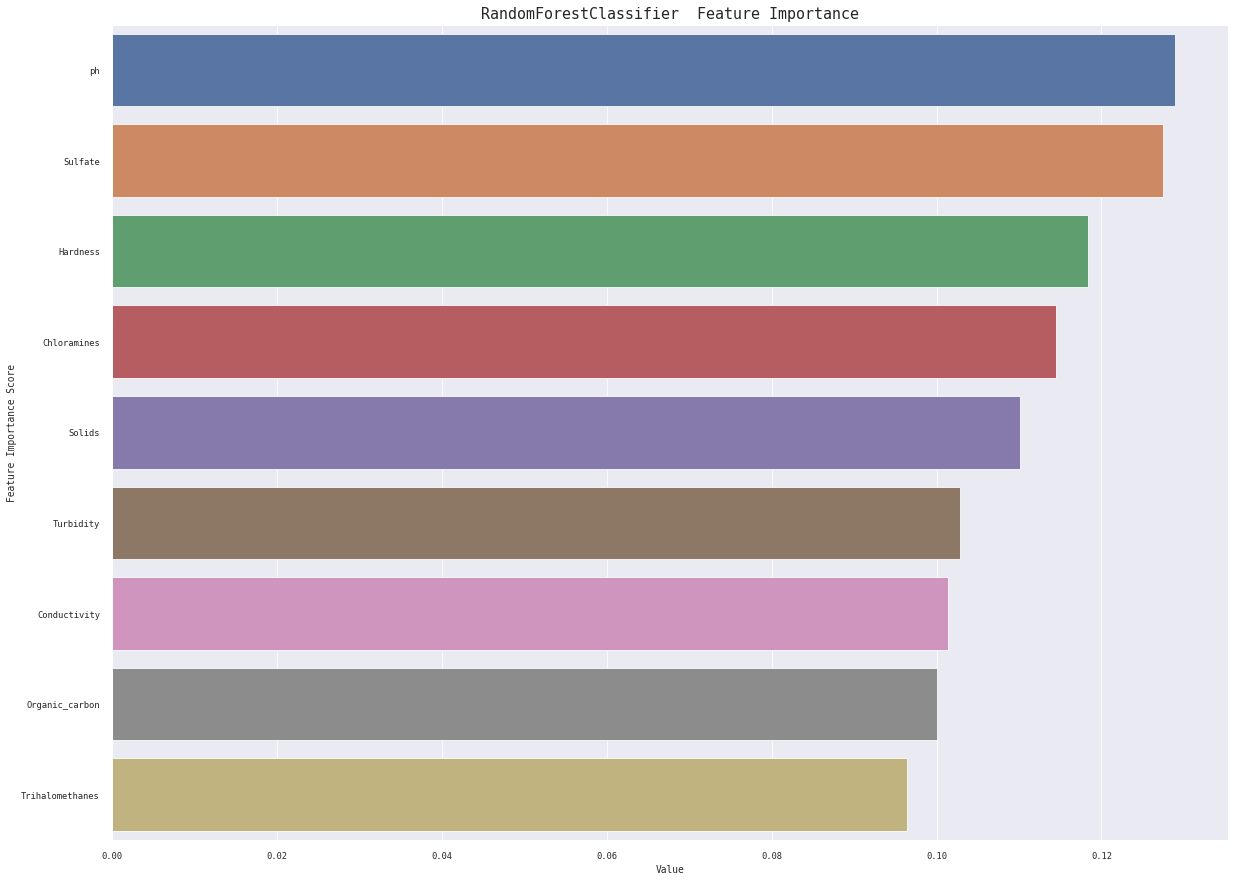

In [26]:
importance_plot(rf_1, X) 

### Catboost

Fold 1 F1-score: 0.7082211106835963
Fold 1 ROC-AUC score: 0.7540816326530612
Fold 5 F1-score: 0.6410256410256411
Fold 5 ROC-AUC score: 0.6510204081632653
Fold 9 F1-score: 0.6338741077222583
Fold 9 ROC-AUC score: 0.7676767676767677
Fold 13 F1-score: 0.6961038961038961
Fold 13 ROC-AUC score: 0.762077922077922
Fold 17 F1-score: 0.6727272727272727
Fold 17 ROC-AUC score: 0.7631168831168831
Fold 21 F1-score: 0.7194805194805195
Fold 21 ROC-AUC score: 0.8015584415584416
Fold 25 F1-score: 0.6592244418331374
Fold 25 ROC-AUC score: 0.731948051948052

Avg F1 score: 0.6361 
Avg ROC-AUC score: 0.6989 


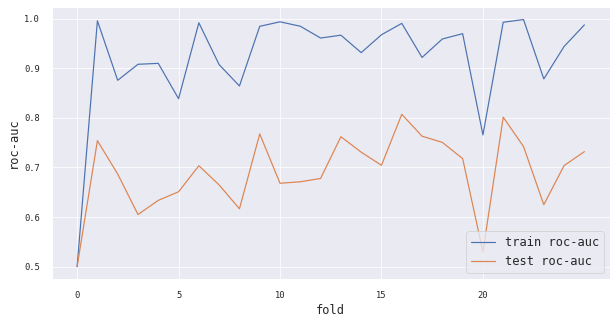

In [24]:
import catboost as cb 

cb_ = cb.CatBoostClassifier(verbose=0)
cb_matrix, cb_report, cb_1, cb_pred = fit_predict(cb_, X, y, 25, test_df, sampling=True)  

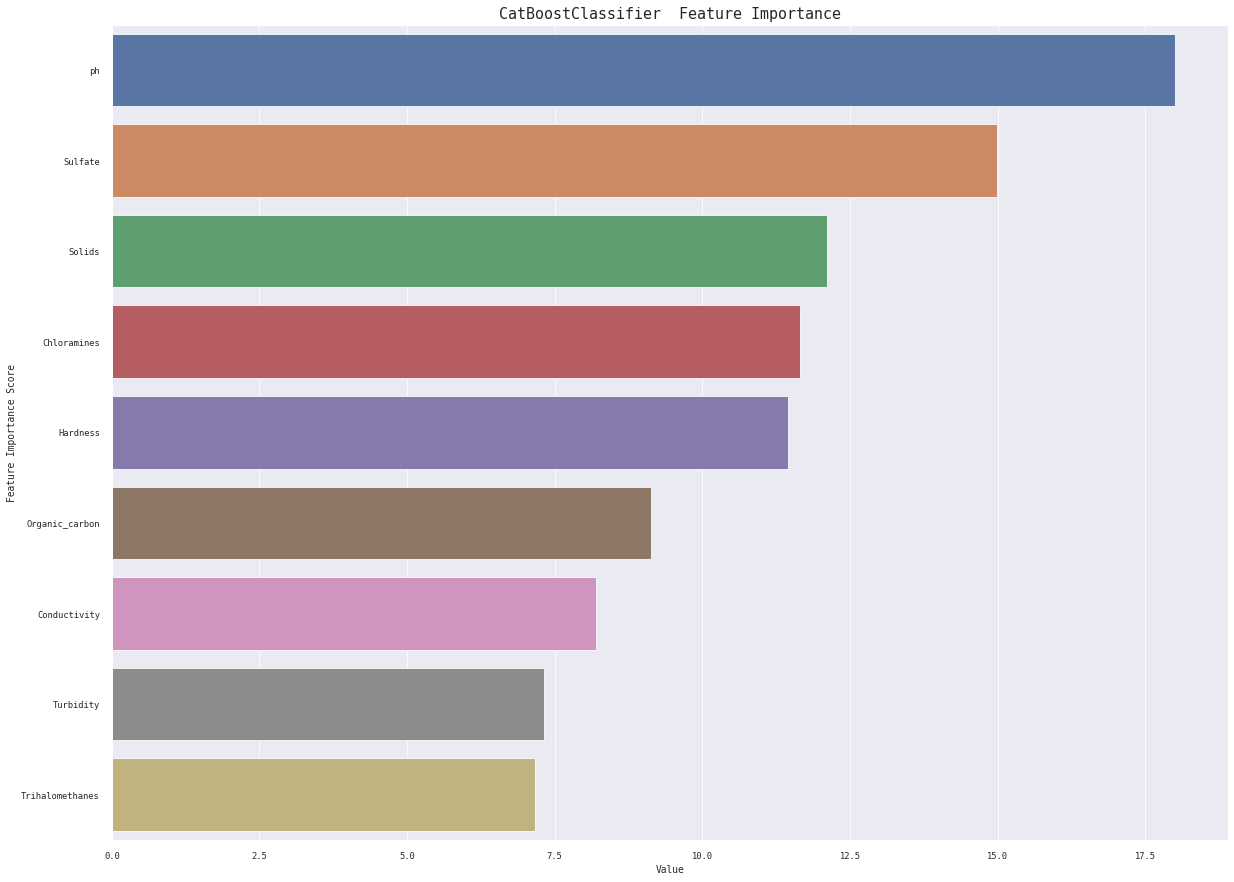

In [28]:
importance_plot(cb_1, X) 

### Tune catboost 

In [31]:
def objective(trial):
    kf = StratifiedKFold(25)
    
    for train_index, valid_index in kf.split(X, y):
        train_x, valid_x = X.iloc[train_index], X.iloc[valid_index]
        train_y, valid_y = y.iloc[train_index], y.iloc[valid_index] 

        over = SMOTE(random_state=1)
        under = RandomUnderSampler(random_state=1)
        steps = [('o', over), ('u', under)]
        pipeline = Pipeline(steps=steps)

        # resample train dataset
        train_x, train_y = pipeline.fit_resample(train_x, train_y)

    param = {
        "verbose": 0, 
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "n_estimators": trial.suggest_int("n_estimators", 4000, 10000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 6, 10),
        "reg_lambda": trial.suggest_int("reg_lambda", 200, 500),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=300)

    preds = gbm.predict(valid_x)
    accuracy = roc_auc_score(valid_y, preds)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value)) 

[I 2021-09-23 12:30:48,524] A new study created in memory with name: no-name-97817a88-b0a5-4e66-b478-8114ea4135ac
[I 2021-09-23 12:30:56,031] Trial 0 finished with value: 0.5558441558441558 and parameters: {'objective': 'CrossEntropy', 'n_estimators': 7214, 'learning_rate': 0.0837994526819336, 'depth': 10, 'reg_lambda': 394, 'bootstrap_type': 'Bernoulli', 'subsample': 0.15809143224202166}. Best is trial 0 with value: 0.5558441558441558.
[I 2021-09-23 12:30:57,282] Trial 1 finished with value: 0.5753246753246753 and parameters: {'objective': 'CrossEntropy', 'n_estimators': 7887, 'learning_rate': 0.05401778506796959, 'depth': 7, 'reg_lambda': 389, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8548842022680987}. Best is trial 1 with value: 0.5753246753246753.
[I 2021-09-23 12:31:01,588] Trial 2 finished with value: 0.5402597402597402 and parameters: {'objective': 'Logloss', 'n_estimators': 7835, 'learning_rate': 0.05069645415642755, 'depth': 9, 'reg_lambda': 500, 'bootstrap_type': 'MVS'}.

Number of finished trials: 100
Best trial:
  Value: 0.6441558441558441
  Params: 
    objective: Logloss
    n_estimators: 8929
    learning_rate: 0.05906139242733704
    depth: 6
    reg_lambda: 338
    bootstrap_type: Bernoulli
    subsample: 0.7380332132480758


Fold 1 F1-score: 0.7113310493592184
Fold 1 ROC-AUC score: 0.7505102040816326
Fold 5 F1-score: 0.5884366214399218
Fold 5 ROC-AUC score: 0.6377551020408163
Fold 9 F1-score: 0.6420505012054308
Fold 9 ROC-AUC score: 0.7363636363636364
Fold 13 F1-score: 0.681174089068826
Fold 13 ROC-AUC score: 0.7225974025974026
Fold 17 F1-score: 0.6457142857142857
Fold 17 ROC-AUC score: 0.7158441558441558
Fold 21 F1-score: 0.6759259259259258
Fold 21 ROC-AUC score: 0.758961038961039
Fold 25 F1-score: 0.6314885748249901
Fold 25 ROC-AUC score: 0.7184415584415584

Avg F1 score: 0.6189 
Avg ROC-AUC score: 0.6885 


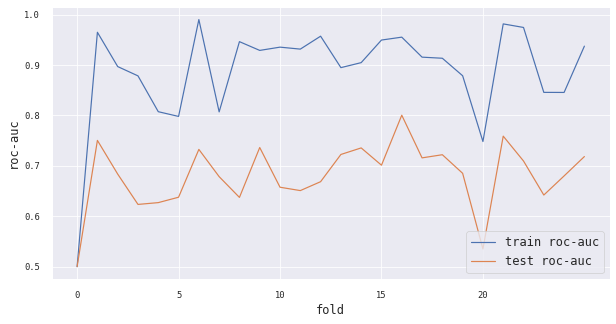

In [32]:
cb_t = cb.CatBoostClassifier(verbose=0, **trial.params)
cb_matrix_t, cb_report_t, cb_model_t, cb_pred_t = fit_predict(cb_t, X, y, 25, test_df, sampling=True)  

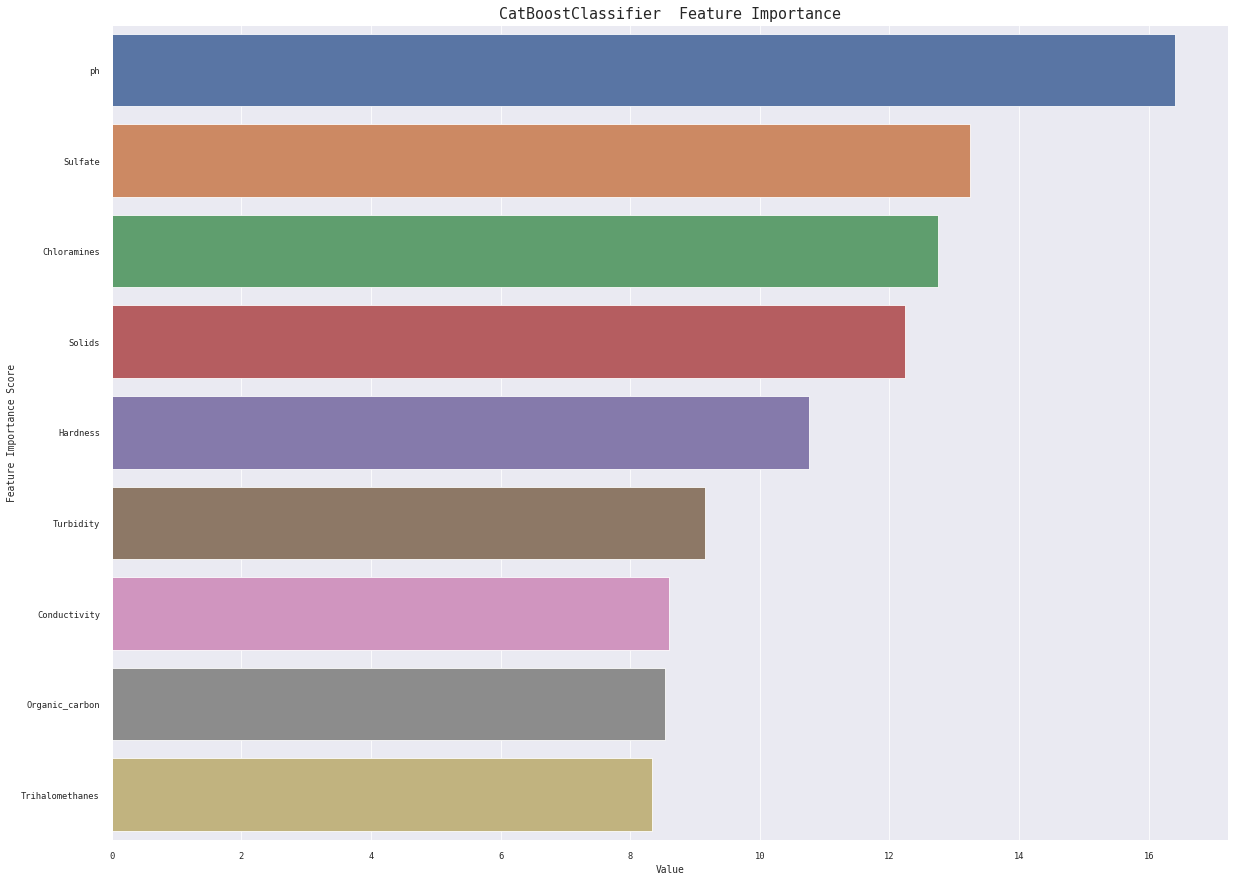

In [81]:
importance_plot(cb_model_t, X) 

### LightGBM

Fold 1 F1-score: 0.651082251082251
Fold 1 ROC-AUC score: 0.7275510204081633
Fold 5 F1-score: 0.6225964559507351
Fold 5 ROC-AUC score: 0.6479591836734694
Fold 9 F1-score: 0.6381941772476594
Fold 9 ROC-AUC score: 0.7237373737373738
Fold 13 F1-score: 0.6759259259259258
Fold 13 ROC-AUC score: 0.7407792207792208
Fold 17 F1-score: 0.6787353391126976
Fold 17 ROC-AUC score: 0.7251948051948053
Fold 21 F1-score: 0.6650717703349283
Fold 21 ROC-AUC score: 0.7579220779220779
Fold 25 F1-score: 0.7163865546218489
Fold 25 ROC-AUC score: 0.7174025974025975

Avg F1 score: 0.6218 
Avg ROC-AUC score: 0.6849 


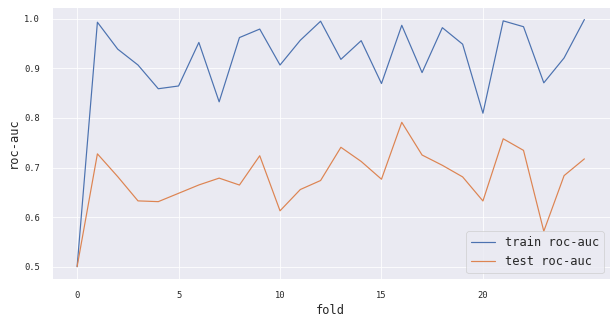

In [28]:
import lightgbm as lgb

lgb_ = lgb.LGBMClassifier() 
lgb_matrix, lgb_report, lgb_1, lgb_pred = fit_predict(lgb_, X, y, 25, test_df, sampling=True) 

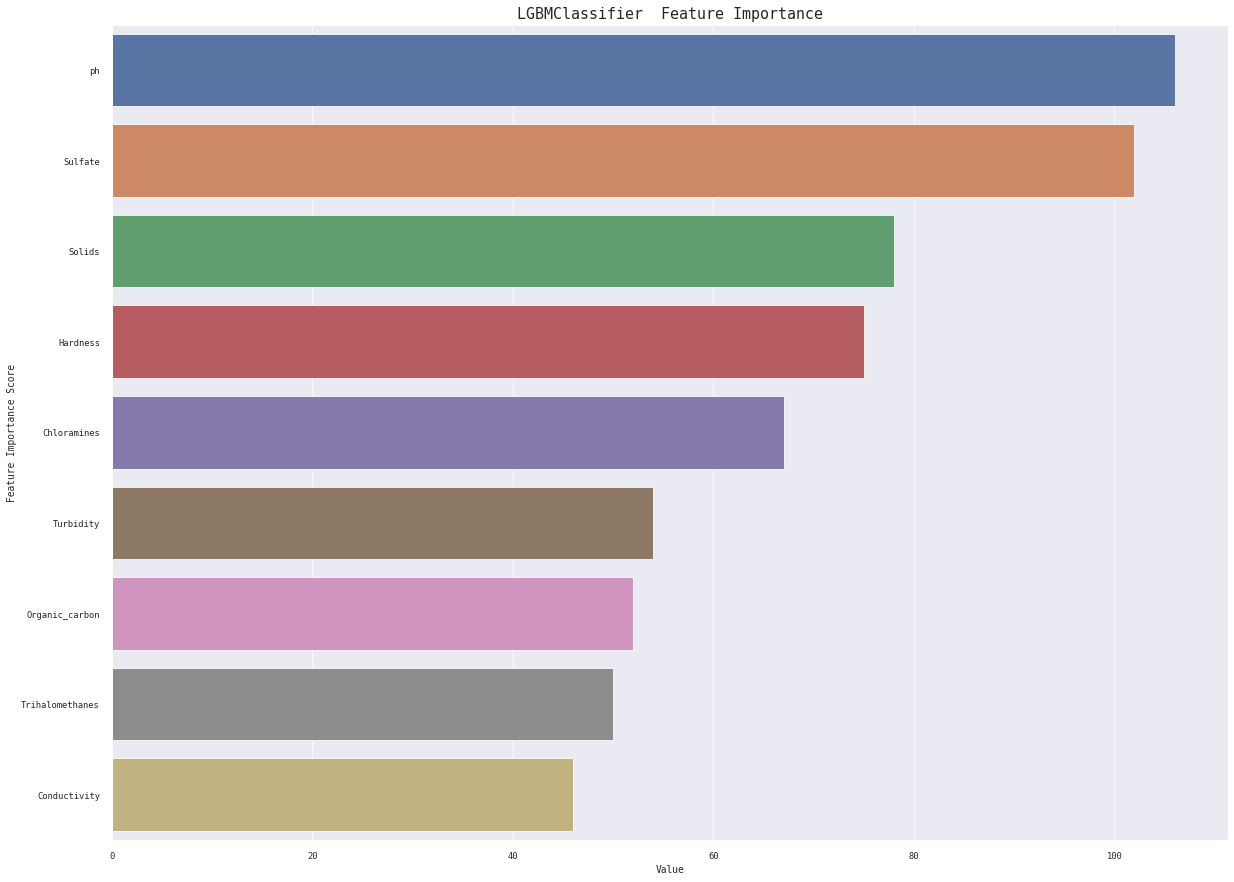

In [30]:
importance_plot(lgb_1, X)

### Tune XGb and Rf

In [31]:
# model_params = {
#     'XGB':
#     {
#         'model':xgb.XGBClassifier(eval_metric='logloss'),
#         'params':
#         {
#             'learning_rate':[0.0001,0.001,0.01,0.1],
#             'n_estimators':[100,200,500,1000],
#             # 'max_features':['sqrt','log2'],
#             'max_depth':list(range(11))
#         }
#     },
#     'Random Forest':
#     {
#         'model':RandomForestClassifier(),
#         'params':
#         {
#             'n_estimators':[10,50,100,200],
#             'max_features':['auto','sqrt','log2'],
#             'max_depth':list(range(1,11))
#         }
#     }
# }

In [32]:
# from sklearn.model_selection import RandomizedSearchCV,RepeatedStratifiedKFold

# cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=2)
# scores=[]
# for model_name,params in model_params.items():
#     rs = RandomizedSearchCV(params['model'],params['params'],cv=cv,n_iter=20)
#     rs.fit(X,y)
#     scores.append([model_name,dict(rs.best_params_),rs.best_score_])
# data=pd.DataFrame(scores,columns=['Model','Parameters','Score'])
# data 

In [33]:
# from sklearn.ensemble import VotingClassifier

# param=data['Parameters']
# models_1 = [('XGB',xgb.XGBClassifier(eval_metric='logloss', **param[0])),
#             ('RF',RandomForestClassifier(**param[1]))]
                                    
# model = VotingClassifier(estimators=models_1, voting='soft') 
# vot_matrix, vot_report, vot_1, vot_pred = fit_predict(model, X, y, 25, test_df)  

### Tune Xgboost

In [34]:
import optuna 

In [33]:
def objective(trial):
    kf = StratifiedKFold(25)
    
    for train_index, valid_index in kf.split(X, y):
        train_x, val_x = X.iloc[train_index], X.iloc[valid_index]
        train_y, val_y = y.iloc[train_index], y.iloc[valid_index]

        over = SMOTE(random_state=1)
        under = RandomUnderSampler(random_state=1)
        steps = [('o', over), ('u', under)]
        pipeline = Pipeline(steps=steps)

        # resample train dataset
        train_x, train_y = pipeline.fit_resample(train_x, train_y)

    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(val_x, label=val_y)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "n_estimators": trial.suggest_int("n_estimators", 1000, 5000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    accuracy = roc_auc_score(val_y, preds)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2021-09-23 12:34:32,587] A new study created in memory with name: no-name-7994a6a2-2a28-4e8e-be6c-e114c5079607
[I 2021-09-23 12:34:33,148] Trial 0 finished with value: 0.5088311688311689 and parameters: {'n_estimators': 3701, 'learning_rate': 0.023036142715345802, 'booster': 'gbtree', 'lambda': 0.02787815683917948, 'alpha': 0.0012668342985768424, 'max_depth': 9, 'eta': 7.757899150221194e-05, 'gamma': 1.359055549726078e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.5088311688311689.
[I 2021-09-23 12:34:33,414] Trial 1 finished with value: 0.5545454545454546 and parameters: {'n_estimators': 2181, 'learning_rate': 0.0791712753202861, 'booster': 'dart', 'lambda': 0.4168579461327824, 'alpha': 0.9717177311682852, 'max_depth': 5, 'eta': 0.11453085188041484, 'gamma': 1.971990245872074e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0021300394273854784, 'skip_drop': 0.0008853304857963287}. Best is trial 1 with value: 0.554

Number of finished trials:  100
Best trial:
  Value: 0.6470129870129869
  Params: 
    n_estimators: 4346
    learning_rate: 0.021316497283698617
    booster: dart
    lambda: 0.04538921464892939
    alpha: 0.0049508721196514964
    max_depth: 2
    eta: 1.8114796118032264e-07
    gamma: 0.08142932337173865
    grow_policy: depthwise
    sample_type: uniform
    normalize_type: forest
    rate_drop: 6.0397964015771786e-06
    skip_drop: 4.4150803408286037e-08


In [34]:
xgb_t = xgb.XGBClassifier(**trial.params)   
xgb_matrix_t, xgb_report_t, xgb_model_t, xgb_pred_t = fit_predict(xgb_t, X, y, 25, test_df, sampling=True) 

Fold 1 F1-score: 0.6106832905512773
Fold 1 ROC-AUC score: 0.6816326530612246
Fold 5 F1-score: 0.42597402597402595
Fold 5 ROC-AUC score: 0.5242346938775511
Fold 9 F1-score: 0.6381941772476594
Fold 9 ROC-AUC score: 0.6994949494949495


KeyboardInterrupt: 

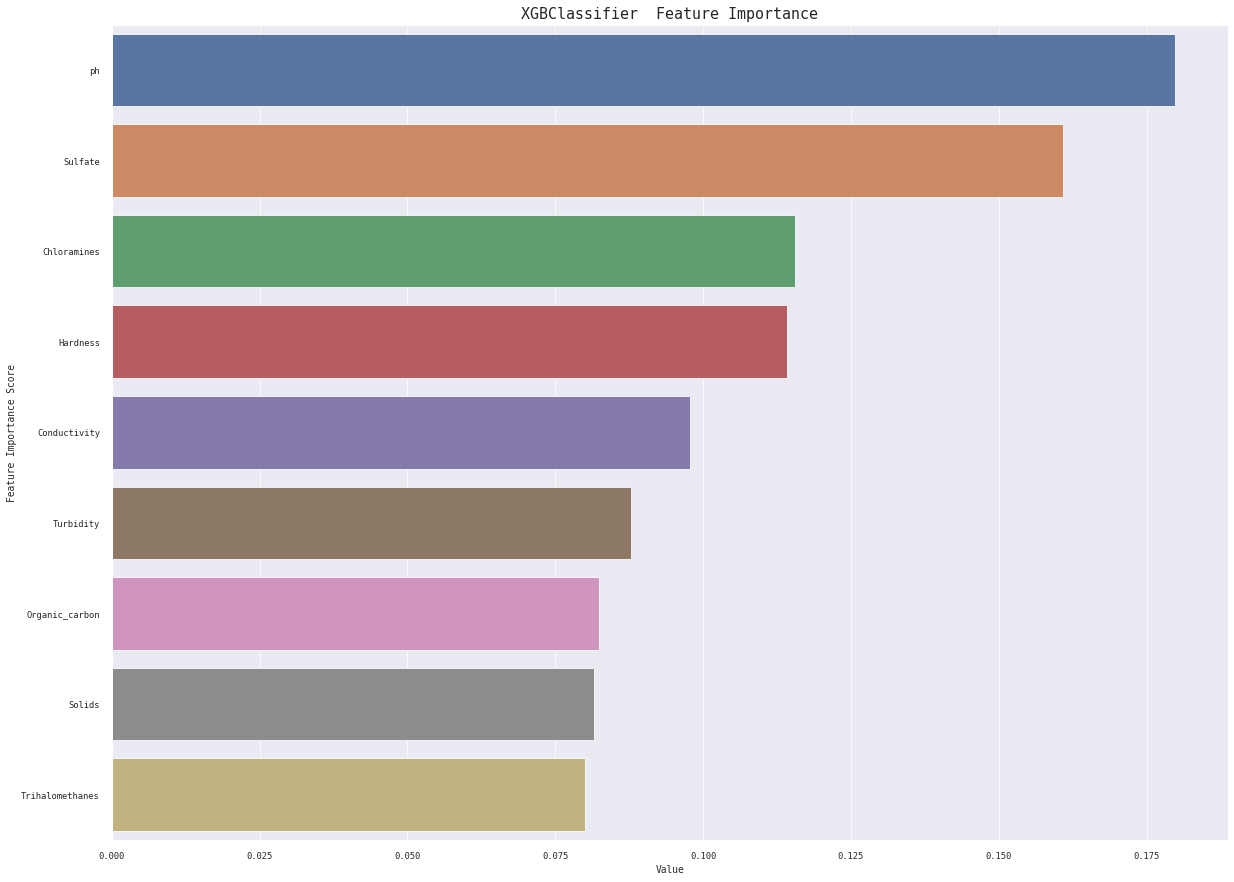

In [37]:
importance_plot(xgb_t, X)

### Ensemble

In [77]:
models = []
models.append(('cb1', cb_1)) 
models.append(('xgb1', xgb_1))
models.append(('cb_t', cb_model_t))
# models.append(('lgb1', lgb_1))
models.append(('svc', sv_1)) 
# models.append(('rf', rf_1)) 

Fold 1 F1-score: 0.6882375333079559
Fold 1 ROC-AUC score: 0.7479591836734694
Fold 5 F1-score: 0.5589285714285714
Fold 5 ROC-AUC score: 0.5571428571428572
Fold 9 F1-score: 0.5958634691029057
Fold 9 ROC-AUC score: 0.6717171717171717
Fold 13 F1-score: 0.6592244418331374
Fold 13 ROC-AUC score: 0.6976623376623378
Fold 17 F1-score: 0.6363146551724138
Fold 17 ROC-AUC score: 0.7714285714285714
Fold 21 F1-score: 0.751131221719457
Fold 21 ROC-AUC score: 0.8171428571428572
Fold 25 F1-score: 0.6989966555183946
Fold 25 ROC-AUC score: 0.72

Avg F1 score: 0.6160 
Avg ROC-AUC score: 0.6722 


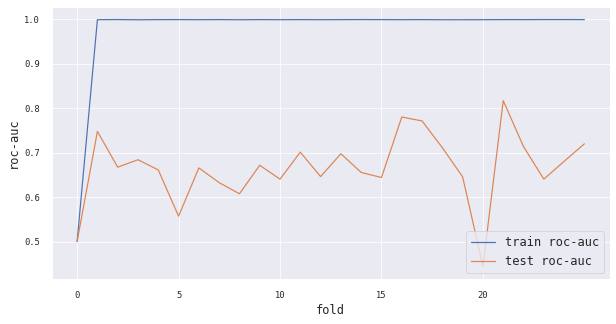

In [78]:
from sklearn.ensemble import VotingClassifier

vot = VotingClassifier(estimators=models,
                       voting='soft',
                       verbose=False) 
vot_matrix, vot_report, vot_1, vot_pred = fit_predict(vot, X, y, 25, test_df, sampling=True)   

## Submit

In [79]:
model_name = []
for i in range(len(Model)):
    model_name.append(type(Model[i]).__name__)
print(model_name)

['SVC', 'XGBClassifier', 'RandomForestClassifier', 'CatBoostClassifier', 'LGBMClassifier', 'XGBClassifier', 'VotingClassifier', 'CatBoostClassifier', 'CatBoostClassifier', 'VotingClassifier']


In [80]:
df = pd.DataFrame({'Model': model_name, 
                   'F1-Score': F1Score}) 
df.sort_values('F1-Score', ascending=False) 

,Model,F1-Score
3,CatBoostClassifier,0.633345
7,CatBoostClassifier,0.621864
8,CatBoostClassifier,0.621864
9,VotingClassifier,0.616047
0,SVC,0.614179
1,XGBClassifier,0.610735
6,VotingClassifier,0.607400
4,LGBMClassifier,0.602743
2,RandomForestClassifier,0.569334
5,XGBClassifier,0.558050


In [35]:
sub_df['Potability'] = cb_pred  

In [36]:
sub_df.sample(5) 

,region_area_,Potability
913,region_area_716,0
452,region_area_232,0
626,region_area_2862,0
453,region_area_2323,1
99,region_area_1271,0


In [63]:
sub_df.to_csv("sub-cb-1.csv", index=False)  